In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [38]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np
import numba

import matplotlib.pyplot as plt

import utils
from utils import moving_average
from loss_functions import LeastSquaresLoss, BaseOracle
from methods import *

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [4]:
np.random.seed(0)


n = 1000
d = 100
noise = 0.3

dataset_name = f"synthetic"

oracle = LeastSquaresLoss()

A = np.random.randn(n, d)
wOpt = np.random.randn(d)
b = A@wOpt + noise * np.random.rand(n)

train_data = A.copy()
train_target = b.copy()
test_data = train_data.copy()
test_target = train_target.copy()

dataset = train_data, train_target, test_data, test_target
batch_size = train_data.shape[0]

wOpt = np.linalg.inv(A.T@A) @ (A.T @ b)
L = np.max(np.linalg.eig(np.matmul(A.T,A))[0]) / n
f_star = oracle.func(wOpt, A, b)

if f_star < 1e-20: f_star = 0.0

f_star

# Can we find a problem where true f* is 100, but setting \bar{f*} for SPS_max too small (e.g 10^-6) 
# will make it not converge. 
# What problem has f* == 100 ? 
# 1/2 x^T Ax - b^T x + 100 * b^T A^-1 b ??? 

0.013973980072083043

In [67]:
dataset_name = "abalone"
train_data, train_target, test_data, test_target = utils.get_libsvm(dataset_name, test_split=0.0)

# batch_size = train_data.shape[0]
batch_size = 128

wOpt = scipy.sparse.linalg.inv(train_data.T.dot(train_data)).dot(train_data.T.dot(train_target))
L = scipy.sparse.linalg.svds(train_data)[1][0] ** 2

oracle = LeastSquaresLoss()
fOpt = oracle.func(wOpt, train_data, train_target)
print(f"{fOpt=}")

print(f"{1/L=}")
print(f"{batch_size=}")
print(f"{train_data.shape=}, {test_data.shape=}")

dataset = train_data, train_target, test_data, test_target

fOpt=2.5242960974670305
1/L=0.4887938843959205
batch_size=128
train_data.shape=(4177, 8), test_data.shape=(4177, 8)


In [68]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markeredgecolor=None, markersize=8,
            f_star=None, suptitle=None, prefix="train",
            x_labels=None, y_labels=None, alphas=None,
            threshold=1e-10, xlims=None, tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
        
    if alphas is None:
        alphas = [1.0 for x in histories]
        
    # if f_star is None:
    #     f_star = np.min([x["loss"] for x in histories])
    # else:
    #     f_star = np.min([f_star for x in histories])
    
    ma_factor = 20
    
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        f_suboptim = history[f"{prefix}/loss"] - f_star
        f_suboptim = moving_average(f_suboptim, len(f_suboptim) // ma_factor)
        
        try:
            markevery = [x + np.random.randint(0, 5) for x in range(0, len(history[f"{prefix}/loss"]) - 5, len(history["test/loss"]) // 10)]
        except:
            markevery = []
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        res = history[f"{prefix}/grad_norm_sq"]
        res = moving_average(res, len(res) // ma_factor)
        ax[1].semilogy(res, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history["lr"]) - 5, len(history["lr"]) // 5)]
        except:
            markevery = []
        
        res = history["lr"]
        if alpha != 1.0:
            ax[2].semilogy(res, linestyle=ls, linewidth=lw, color=c, alpha=alpha)
            ax[2].semilogy(moving_average(res, len(res) // ma_factor), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        else:
            ax[2].semilogy(res, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$(f(x_k) - f^*)$")
        ax[1].set_ylabel(r"$\| f(x_k) \|^2$")
        
    ax[2].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Steps")


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])

    fig.legend()
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "experiments/plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()    

In [69]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params = np.random.randn(train_data.shape[1])
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LeastSquaresLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss = loss_function.func(params, train_data, train_target)
    grad = loss_function.grad(params, train_data, train_target)
    
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss = loss_function.func(params, test_data, test_target)
    grad = loss_function.grad(params, test_data, test_target)
    
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    for epoch in range(n_epochs):
                
        # Training 
        if batch_size != train_data.shape[0]: # If full batch then don't shuffle indices
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss = loss_function.func(params, batch_data, batch_target)
            train_grad = loss_function.grad(params, batch_data, batch_target)

            if optim.__class__.__name__ == "SLS":
                def closure(params):
                    return loss_function.func(params, batch_data, batch_target)
                optim.step(loss=train_loss, grad=train_grad, closure=closure)
            else:
                optim.step(loss=train_loss, grad=train_grad)

            history["lr"].append(optim.lr)

        # Train Evaluation 
        loss = loss_function.func(params, train_data, train_target)
        grad = loss_function.grad(params, train_data, train_target)
        
        g_norm_sq = np.linalg.norm(grad)**2
        history["train/loss"].append(loss)
        history["train/grad_norm_sq"].append(g_norm_sq)
        
        # Test Evaluation 
        loss = loss_function.func(params, test_data, test_target)
        grad = loss_function.grad(params, test_data, test_target)
        
        g_norm_sq = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/grad_norm_sq"].append(g_norm_sq)
    
    return history

In [70]:
class SPS(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 c: float = 0.5, 
                 eps: float = 0.0,
                 f_star: float = 0.0,
                 eta_max: float = np.inf):
        
        self.params = params
        self.lr = 1.0
        self.eps = eps
        self.f_star = f_star
        self.c = c
        self.eta_max = eta_max
        
        self.defaults = dict(
            lr=1.0,
            c=c,
            eps=eps,
            )
        
    def step(self, loss, grad):
        
        self.lr = (loss - self.f_star) / ( self.c * np.linalg.norm(grad)**2 + self.eps )
        self.lr = np.minimum(self.eta_max, self.lr)
        self.params -= self.lr * grad
            
        return loss, grad


class SPS_MA(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, 
                 c: float = 0.5, 
                 eps: float = 1e-8,
                 eta_max: float = 0.0,
                 betas: tuple[float, float] = (0.9, 0.9)):
        
        self.params = params
        self.lr = 1.0
        self.eps = eps
        self.c = c
        self.betas = betas
        self.eta_max = eta_max
        
        self.defaults = dict(
            lr=1.0,
            c=c,
            eps=eps,
            )
        
        self._step_t = 0
        
        self.sum_f = 0.0
        self.sum_g = np.zeros_like(self.params)
        
    def step(self, loss, grad):
        
        self._step_t += 1
        
        self.sum_f = self.betas[0] * self.sum_f + (1 - self.betas[0]) * loss
        self.sum_g = self.betas[1] * self.sum_g + (1 - self.betas[1]) * grad
        # sum_hat = self.sum_g / (1 - self.beta**self._step_t)

        self.lr = self.sum_f / ( self.c * np.linalg.norm(self.sum_g)**2 + self.eps )        
        self.params -= self.lr * grad
            
        return loss, grad

In [45]:
def twin_polyak(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LeastSquaresLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad = loss_function.func(params_x, train_data, train_target), loss_function.grad(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad = loss_function.func(params_x, test_data, test_target), loss_function.grad(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    eps = 0.0
    
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x = loss_function.func(params_x, batch_data, batch_target), loss_function.grad(params_x, batch_data, batch_target)
            loss_y, grad_y  = loss_function.func(params_y, batch_data, batch_target), loss_function.grad(params_y, batch_data, batch_target)
    
            lr_x = np.minimum(( (loss_x - loss_y) / (0.5 * np.linalg.norm(grad_x)**2 + eps) ), np.inf) 
            lr_y = np.minimum(( (loss_y - loss_x) / (0.5 * np.linalg.norm(grad_y)**2 + eps) ), np.inf) 

            # Optimization step
            if loss_x > loss_y:
                params_x -= lr_x * grad_x
                lr = lr_x
            else:
                params_y -= lr_y * grad_y
                lr = lr_y
                
            history["bound_c"].append( np.abs(loss_x - loss_y) / (np.maximum(loss_x, loss_y) - fOpt))
            history["bound_d"].append( (loss_y - fOpt) / (loss_x - fOpt) )
            history["bound_dd"].append( (np.minimum(loss_x, loss_y) - fOpt) / (np.maximum(loss_x, loss_y) - fOpt) )
            
            history["lr_x"].append(np.abs(lr_x))
            history["lr_y"].append(np.abs(lr_y))
            history["lr"].append(lr)
            
            
        # Train Evaluation 
        loss_x, grad_x = loss_function.func(params_x, train_data, train_target), loss_function.grad(params_x, train_data, train_target)
        loss_y, grad_y = loss_function.func(params_y, train_data, train_target), loss_function.grad(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, g_norm_sq = loss_x, grad_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, g_norm_sq = loss_y, grad_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x = loss_function.func(params_x, test_data, test_target), loss_function.grad(params_x, test_data, test_target)
        loss_y, grad_y = loss_function.func(params_y, test_data, test_target), loss_function.grad(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, g_norm_sq = loss_x, grad_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, g_norm_sq = loss_y, grad_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

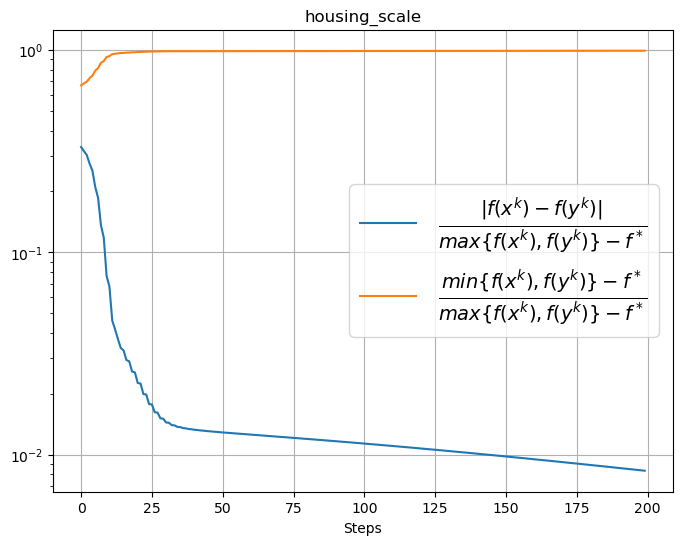

In [37]:
n_epochs = 200
seed = 0

plt.figure(figsize=(8, 6))

hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs,
                       seed=seed)

plt.semilogy(hist_twin["bound_c"], label=r"$\frac{|f(x^k) - f(y^k)|}{max\{f(x^k), f(y^k)\} - f^*}$")
plt.semilogy(hist_twin["bound_dd"], label=r"$\frac{min\{f(x^k), f(y^k)\} - f^*}{max\{f(x^k), f(y^k)\} - f^*}$")


# plt.axline((0.0, 0.0), (50.0, 0.0), linestyle="--", linewidth=3.0, alpha=0.7)
# plt.axline((0.0, 1.0), (50.0, 1.0), linestyle="--", linewidth=3.0, alpha=0.7, color="orange")

plt.xlabel("Steps")

plt.title(dataset_name)
plt.legend(prop={"size": 20})
plt.grid()
plt.savefig(f"plots/{dataset_name}_c_d_bound.pdf")
plt.show()

In [77]:
n_epochs = 100
seed = 0

histories = []
labels = []

# hist_sgd = train_loop(dataset=dataset, 
#                 batch_size=batch_size, 
#                 n_epochs=n_epochs, 
#                 optimizer=SGD,
#                 seed=seed, 
#                 lr=1/L,
#                 )
# histories.append(hist_sgd)
# if batch_size == train_data.shape[0]:
#         labels.append("GD 1/L")
# else:
#         labels.append("SGD 1/L")

f_star = 0.0
for eta_max in [0.01, 0.1, 1.0]:
        hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=SPS,
                        seed=seed,
                        f_star=f_star,
                        eta_max=eta_max,
                        eps=0.0,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}}\; \gamma={0}\; f^*={1:.5}$".format(eta_max, f_star) )

hist_sls = train_loop(
        dataset=dataset,
        batch_size=batch_size,
        n_epochs=n_epochs,
        optimizer=SLS,
        seed=seed
        )
histories.append(hist_sls)
labels.append("SLS")

eta_max = 10.0
c_0 = 1.0
hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=DecSPS,
                        seed=seed,
                        eta_max=eta_max,
                        c_0=c_0,
                        eps=0.0,
                        )
histories.append(hist_sps)
labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 

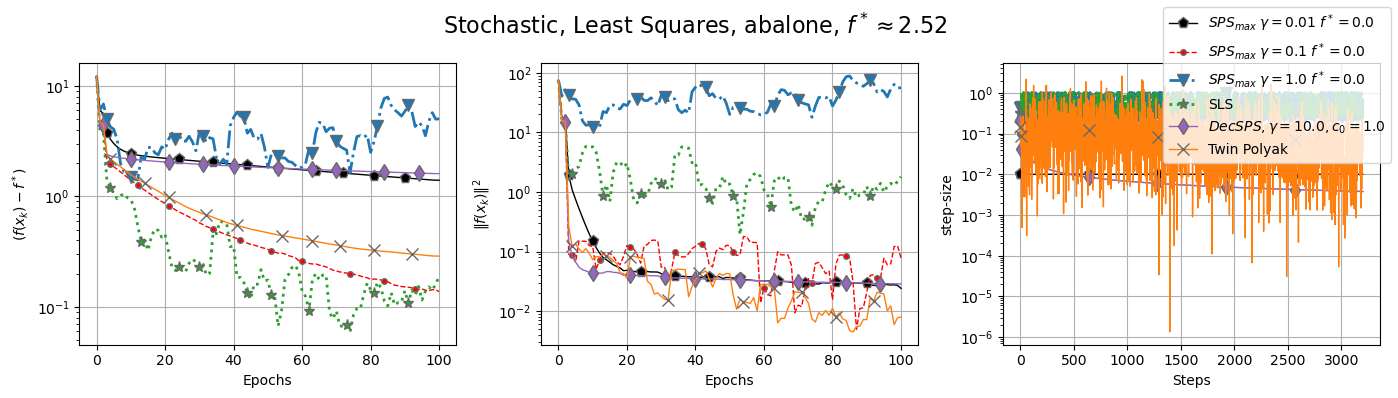

In [78]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.8],
        f_star=fOpt, 
        prefix="train",
        suptitle=r"{0}, Least Squares, {1}, $f^*\approx{2}$".format(setting, dataset_name, round(fOpt, 2)),
        threshold=0.0,
        # filename=f"rand_{dataset_name}_{setting.lower()}_least_sq.pdf",
        )

201
201


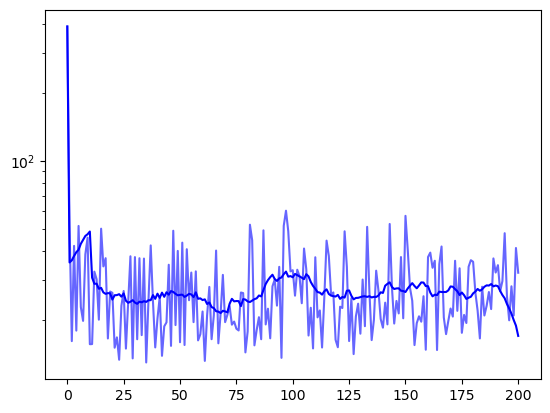

In [ ]:


res = histories[-2]["train/loss"]

print(len(res))
ma = moving_average(res, len(res) // 10)
print(len(ma))

plt.semilogy(res, color="blue", alpha=0.6)
plt.semilogy(ma, color="blue")

In [614]:
n_epochs = 100
seed = 0

histories = []
labels = []

hist_sgd = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SGD,
                seed=seed, 
                lr=1/L,
                )
histories.append(hist_sgd)
if batch_size == train_data.shape[0]:
        labels.append("GD 1/L")
else:
        labels.append("SGD 1/L")

f_star = 0.0
eta_max = 1.0
for f_star, f_star_label in zip([fOpt, 0.9 * fOpt, 0.0], 
                  ["f^*", "0.9*f^*", "0"]):
        hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=SPS,
                        seed=seed,
                        f_star=f_star,
                        eta_max=eta_max,
                        eps=0.0,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}}\; \gamma={0}\; l^*={1}$".format(eta_max, f_star_label) )

eta_max = 10.0
c_0 = 1.0
hist_sps = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=DecSPS,
                seed=seed,
                eta_max=eta_max,
                c_0=c_0,
                eps=1e-10,
                )
histories.append(hist_sps)
labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 

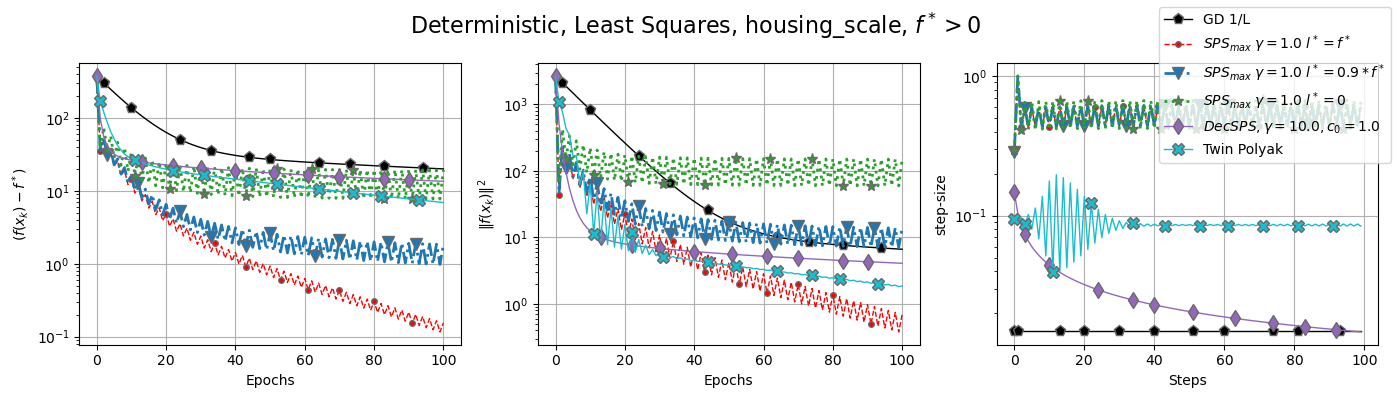

In [616]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=fOpt, 
        prefix="train",
        suptitle=r"{0}, Least Squares, {1}, $f^* > 0$".format(setting, dataset_name),
        threshold=0.0,
        # filename=f"rand_{dataset_name}_{setting.lower()}_least_sq.pdf",
        )

In [ ]:
n_epochs = 100
seed = 0

histories = []
labels = []

eta_max = 10.0
c_0 = 1.0
hist_sps = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=DecSPS,
                seed=seed,
                eta_max=eta_max,
                c_0=c_0,
                eps=1e-10,
                )
histories.append(hist_sps)
labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))

hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)
histories.append(hist_twin)
labels.append("Twin Polyak")

if batch_size == train_data.shape[0]:
        setting = "Deterministic"
else:
        setting = "Stochastic" 